## QSO Plot

In [1]:
%matplotlib notebook
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import pandas as pd
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import tarfile
import sqlite3
import lsst.daf.persistence as dafPersist
sys.path.append('/epyc/users/mrawls/premap2019/ap_pipe-notebooks/')
from apdbPlots import makeSrcTableFlags

In [2]:
hitsDataDir='/epyc/users/mrawls/premap2019/hits-dr1'
hitsFilename='HiTS_DR1_variables_DM-dataset-subset.fits'
hitsFilepath=os.path.join(hitsDataDir,hitsFilename) # Creates file path to the HiTS DR1 database
hitsTable=fits.open(hitsFilepath) # Load data as an astropy fits thing
hitsDf=pd.DataFrame(hitsTable[1].data) # Turn data into a pandas dataframe

In [3]:
hitsDfQSO_filter = hitsDf[hitsDf['QSO_Prob'] > 0.80]
hitsDfQSO = hitsDfQSO_filter.drop(['Variable_prob', 'Periodic_prob', 'DSCT_Prob', 'EB_Prob', 'Predicted_class',
                                   'ROTVAR_Prob', 'RRLYR_Prob', 'CV_Prob', 'SNe_Prob'], axis = 1)

In [4]:
repo = '/epyc/users/mrawls/premap2019/hits-lsst/hits2015/rerun/highres1'
butler = dafPersist.Butler(repo) # Butler function retrieves the data
dbName = 'association.db'
dbPath = os.path.join(repo, dbName) # Joins repo and dbName to form a path to the database
connection = sqlite3.connect(dbPath) # Opens a connection to the database

# Read data from the database to pandas dataframes
objTable = pd.read_sql_query('select diaObjectId, ra, decl, nDiaSources, \
                              gPSFluxMean, gPSFluxMeanErr, \
                              validityEnd, flags, \
                              gTOTFluxMean, gTOTFluxMeanErr \
                              from DiaObject where validityEnd is NULL;', connection) 
srcTableAll = pd.read_sql_query('select diaSourceId, diaObjectId, \
                                  ra, decl, ccdVisitId, \
                                  midPointTai, apFlux, psFlux, apFluxErr, \
                                  psFluxErr, totFlux, totFluxErr, flags \
                                  from DiaSource;', connection)

In [5]:
badFlagList = ['base_PixelFlags_flag_bad', 'base_PixelFlags_flag_suspect', 'base_PixelFlags_flag_saturatedCenter'] 
flagTable, flagValues, srcTableFlags, flagFilter, noFlagFilter, \
    goodSrc, goodObj = makeSrcTableFlags(srcTableAll, objTable)

/epyc/users/mrawls/lsst_stack/stack/miniconda3-4.5.12-f032070/Linux64/ap_association/18.1.0-14-g371438c+1/python/lsst/ap/association/mapApData.py:388: YAMLLoadWarning: calling yaml.load_all() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  table_list = list(yaml.load_all(yaml_stream))


In [6]:
lsstRas = goodObj.ra
lsstDecs = goodObj.decl
hitsRas = hitsDfQSO.raMedian_feat
hitsDecs = hitsDfQSO.decMedian_feat
# Convert HiTS and LSST coordinates to degrees
hitsCoords = SkyCoord(ra=hitsRas*u.degree, dec=hitsDecs*u.degree)
lsstCoords = SkyCoord(ra=lsstRas*u.degree, dec=lsstDecs*u.degree)
idx, d2d, d3d = hitsCoords.match_to_catalog_sky(lsstCoords)

In [7]:
def plot_objects_on_sky(ra1_first, dec1_first,
                        ra2_first, dec2_first,
                        ra1_second, dec1_second,
                        ra2_second, dec2_second):
    """This function takes two sets of RA and Dec and plots them
    both on the sky in different colors.
    
    It is customized to plot a specific region (three HiTS fields in two panels).
    
    "1" and "2" refer to the two panels in the plot.
    "first" and "second" refer to the two different datasets.
    """
    # Set up the figure object and two axes
    fig = plt.figure(figsize=(13, 13))
    ax1 = plt.subplot2grid((100, 100), (0, 55), rowspan=50, colspan=45)
    ax2 = plt.subplot2grid((100, 100), (0, 0), rowspan=90, colspan=50)

    # Plot the first set of RAs and Decs in blue
    # This will be from the LSST database
    ax1.scatter(ra1_first, dec1_first, marker='.', s=0.5, alpha=0.5, c='C0',label='LSST Objects')
    ax2.scatter(ra2_first, dec2_first, marker='.', s=0.5, alpha=0.5, c='C0',label='LSST Objects')
    
    # Plot the second set of RAs and Decs in red
    # This will be from the HiTS DR1
    ax1.scatter(ra1_second, dec1_second, marker='.', s=15, alpha=0.8, c='red',label='HiTS QSO')
    ax2.scatter(ra2_second, dec2_second, marker='.', s=15, alpha=0.8, c='red',label='HiTS QSO')

    ax1.invert_xaxis()
    ax2.invert_xaxis()
    
    # Label axes and title plot
    plt.xlabel('RA (deg)', fontsize=14)
    plt.ylabel('Dec (deg)', fontsize=14)
    plt.title('View of Objects from LSST and HiTS (QSOs) on the Sky', fontsize=15)
    
    # Increase x and y tick text size
    ax1.tick_params(axis='both', which='major', labelsize=11.5)
    ax1.tick_params(axis='both', which='minor', labelsize=11.5)

    ax2.tick_params(axis='both', which='major', labelsize=11.5)
    ax2.tick_params(axis='both', which='minor', labelsize=11.5)
    
    # Generate legends
    lgnd = ax1.legend(loc="lower right", scatterpoints=1, fontsize=10, prop={'size': 11.5})
    lgnd.legendHandles[0]._sizes = [60]
    lgnd.legendHandles[1]._sizes = [60]
    
    lgnd2 = ax2.legend(loc="lower right", scatterpoints=1, fontsize=10, prop={'size': 11.5})
    lgnd2.legendHandles[0]._sizes = [60]
    lgnd2.legendHandles[1]._sizes = [60]

In [8]:
# Defines filters and parameters to be called by plot_objects_on_sky()
ax1Filter = (goodObj['decl']>-2)
ax2Filter=(~ax1Filter)

ra1_first=goodObj.loc[ax1Filter, 'ra']
dec1_first=goodObj.loc[ax1Filter, 'decl']
ra2_first=goodObj.loc[ax2Filter, 'ra']
dec2_first=goodObj.loc[ax2Filter, 'decl']

ax1Filter_second = (hitsDf['decMedian']>-2)
ax2Filter_second = (~ax1Filter_second)

ra1_second=hitsDfQSO.loc[ax1Filter_second,'raMedian']
dec1_second=hitsDfQSO.loc[ax1Filter_second,'decMedian']
ra2_second=hitsDfQSO.loc[ax2Filter_second,'raMedian']
dec2_second=hitsDfQSO.loc[ax2Filter_second,'decMedian']

<IPython.core.display.Javascript object>


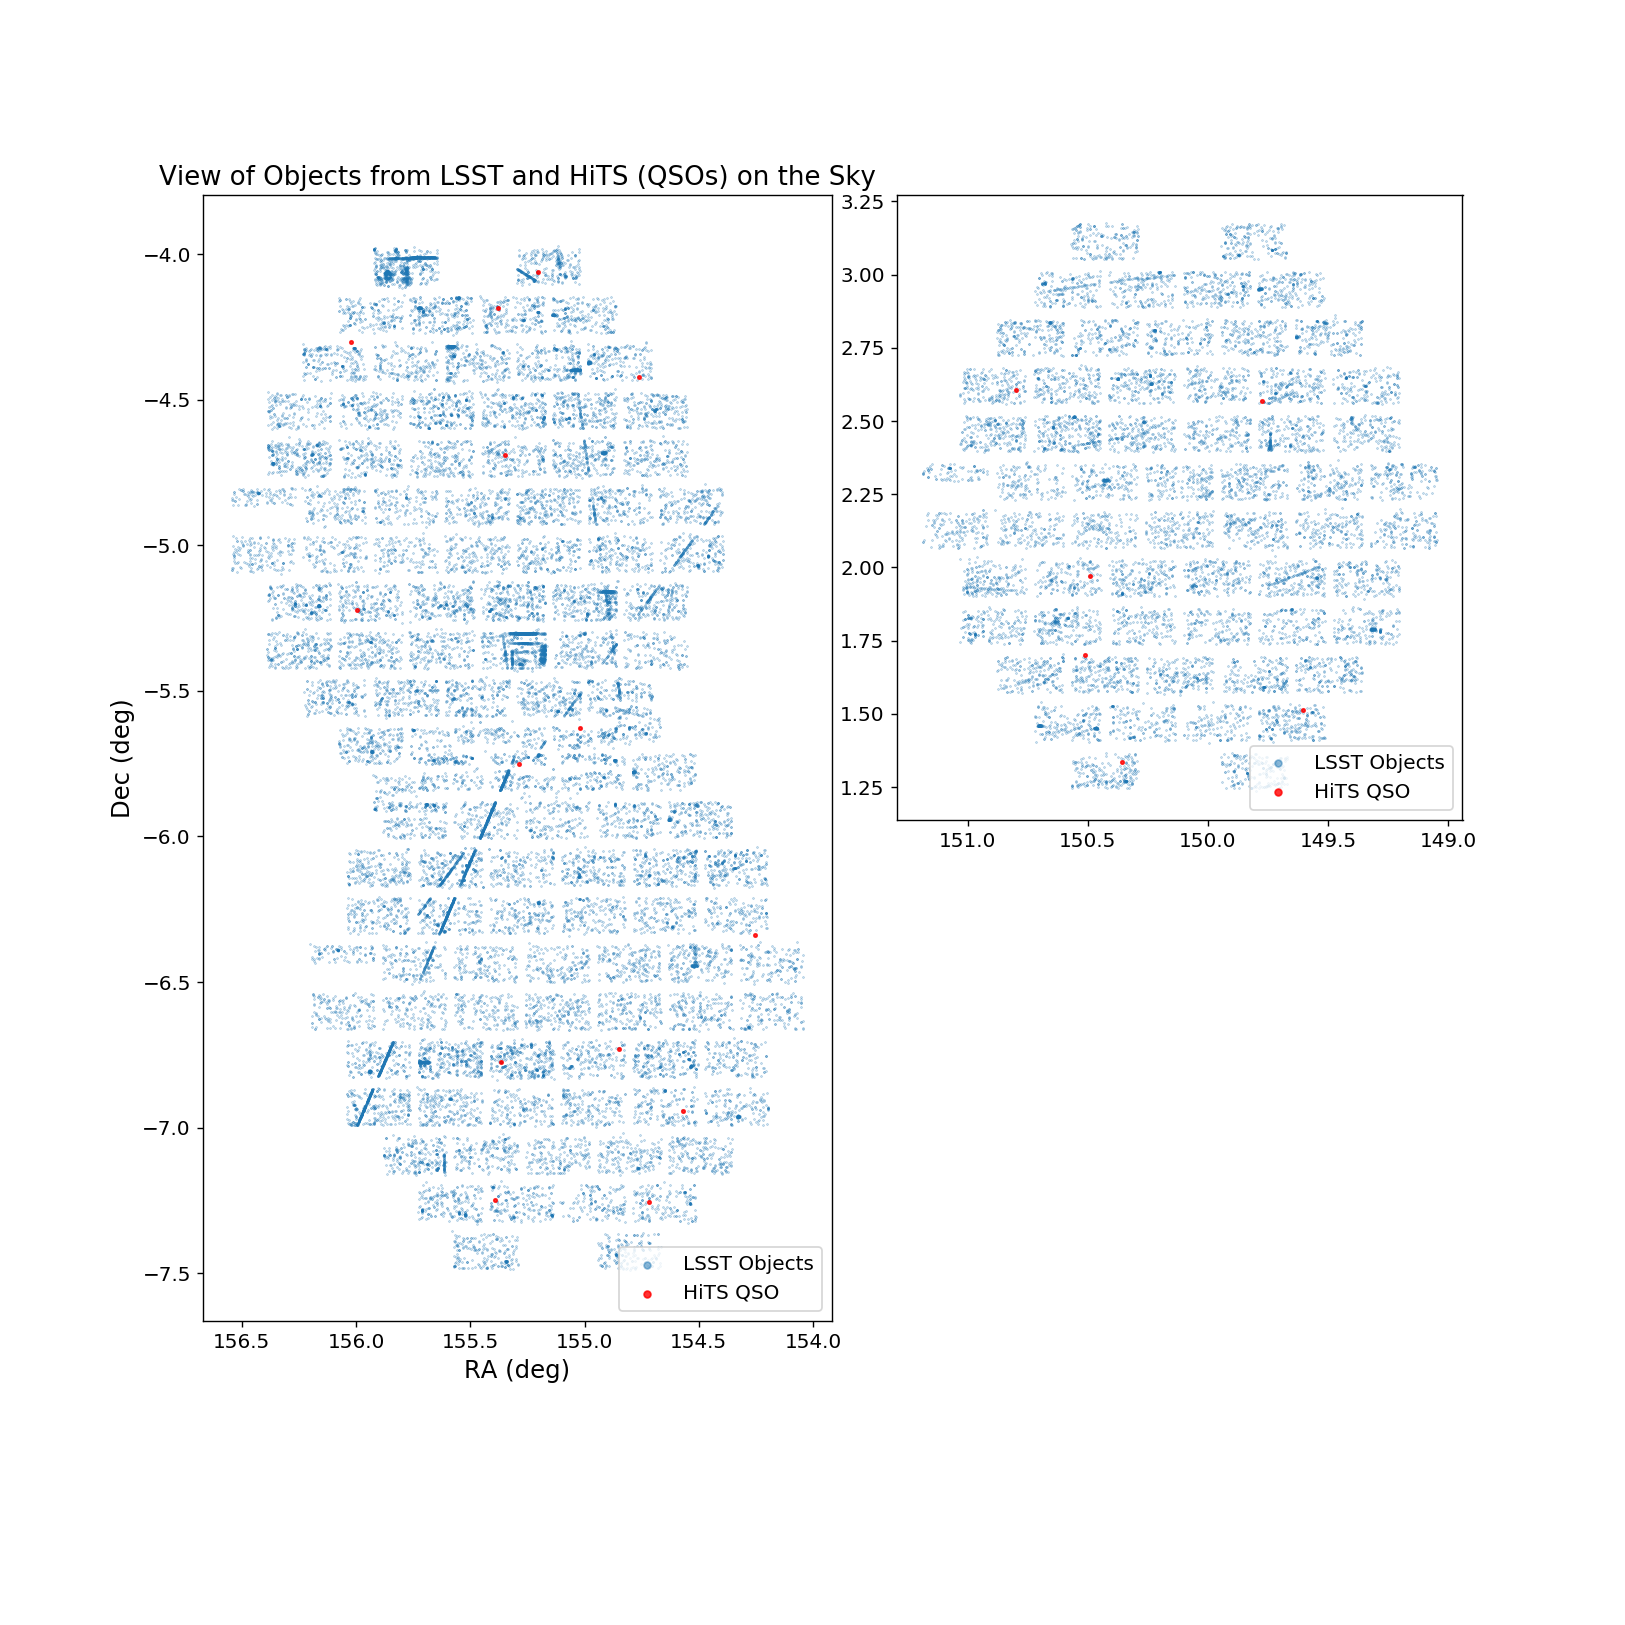

In [9]:
plot_objects_on_sky(ra1_first, dec1_first,
                        ra2_first, dec2_first,
                        ra1_second, dec1_second,
                        ra2_second, dec2_second)